## Some dependencies

In [1]:
#!pip install tensorflow_hub
#!pip install tensorflow_text
#!pip install tf-estimator-nightly==2.4.0.dev2020101001

## Making Necessary Imports

In [87]:
import fitz
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

## Converting pdf files to text files (for history questions)

In [4]:
for i in range(1,10):
    file = fitz.open(f'History/anhi-dca-{i}.pdf')

    for pagenum, page in enumerate(file.pages(),start=1):
        text = page.getText()
        txt = open(f'report{i}.txt','a',encoding='utf-8')
        txt.writelines(text)
        txt.close()

_**Converting one file with a different name separately**_

In [3]:
file = fitz.open('History/Ancient 1.pdf')

for pagenum, page in enumerate(file.pages(),start=1):
    text = page.getText()
    txt = open('report0.txt','a',encoding='utf-8')
    txt.writelines(text)
    txt.close()

## Data Preprocessing (for history questions)

In [5]:
total = []
for i in range(1,10):
    file = open(f'report{i}.txt','r+')
    question = file.read().split('showanswer\n')
    question = [i.strip() for i in question]
    question = [i.replace('\n',' ') for i in question]
    question = [i.partition('[A]')[0] for i in question]
    total.extend(question)

In [6]:
file = open('report0.txt','r+',encoding='utf-8')
add_question = file.read().split('showanswer')
add_question = [i.strip() for i in add_question]
add_question = [i.replace('\n',' ') for i in add_question]
add_question = [i.partition('a)')[0] for i in add_question]
add_question = [i[3:] for i in add_question]
total.extend(add_question)

## Creating dataframe with only history questions

In [7]:
history_df = pd.DataFrame(total,columns=['questions'])

In [8]:
history_df['category'] = 'History'

In [9]:
history_df.head()

,questions,category
0,Hathigumpha inscription gives account of which...,History
1,"As per Asokaâ€™s inscriptions, which among the...",History
2,Which of the following ruler of Satavahana Emp...,History
3,Who presided First Buddhist Council?,History
4,"In which among the following sacrifices, the s...",History


## Converting pdf file to text files (for Science & Tech questions)

In [10]:
for i in range(1,11):
    file = fitz.open(f'Science and Tech/qna-scte-{i}.pdf')

    for pagenum, page in enumerate(file.pages(),start=1):
        text = page.getText()
        txt = open(f'sci_report{i}.txt','a',encoding='utf-8')
        txt.writelines(text)
        txt.close()

## Data Preprocessing (For Science & Tech questions)

In [11]:
sci_tech_questions = []
for i in range(1,11):
    sci_file = open(f'sci_report{i}.txt','r+',encoding='utf-8')
    sci_question = sci_file.readlines()
    sci_question = [i.replace('\n','') for i in sci_question]
    for text in sci_question:
        if ('https://' not in text) and ('?' in text):
            sci_tech_questions.append(text)  

## Creating DataFrame for Science & Tech Questions

In [12]:
sci_tech_df = pd.DataFrame(sci_tech_questions,columns=['questions'])

In [13]:
sci_tech_df['category'] = 'Science&Tech'

In [14]:
sci_tech_df.head()

,questions,category
0,In which decade was the American Institute of ...,Science&Tech
1,What is part of a database that holds only one...,Science&Tech
2,'OS' computer abbreviation usually means ?,Science&Tech
3,In which decade with the first transatlantic r...,Science&Tech
4,'.MOV' extension refers usually to what kind o...,Science&Tech


## Combing both dataframes to form a single questions Dataframe containing all questions and shuffing the dataframe

In [15]:
questions_df = pd.concat([history_df,sci_tech_df])

In [16]:
questions_df

,questions,category
0,Hathigumpha inscription gives account of which...,History
1,"As per Asokaâ€™s inscriptions, which among the...",History
2,Which of the following ruler of Satavahana Emp...,History
3,Who presided First Buddhist Council?,History
4,"In which among the following sacrifices, the s...",History
...,...,...
45,'.JPG' extension refers usually to what kind o...,Science&Tech
46,What does AM mean?,Science&Tech
47,"In what year was the ""@"" chosen for its use in...",Science&Tech
48,'.TXT' extension refers usually to what kind o...,Science&Tech


In [17]:
# shuffling
questions_df = questions_df.sample(frac = 1)

### Reseting the index as it gets disturbed after shuffling

In [18]:
index = list(range(len(questions_df)))
questions_df.index = index

## Final Dataframe

In [19]:
questions_df

,questions,category
0,What was the unit of currency during the Rig V...,History
1,Which of the following is / are correct statem...,History
2,Gandhar art is a combination of ____________ ?,History
3,Which of the following rulers is considered as...,History
4,What is part of a database that holds only one...,Science&Tech
...,...,...
240,"With reference to cultural history of India, ...",History
241,Which of the following was the head of the boa...,History
242,First Buddhist Council was held during the rei...,History
243,Consider the following pairs. Folk paintings...,History


## Using dummy values to encode categorical values in "category" column

In [20]:
questions_df['category'] = pd.get_dummies(questions_df['category'],drop_first=True)

## Performing train-test split(80-20 ratio)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(questions_df['questions'],questions_df['category'], test_size=0.2,stratify=questions_df['category'])

## Now lets import BERT model

In [59]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

## Building Model

In [63]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [64]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer_2 (KerasLayer)      {'input_mask': (None 0           text[0][0]                       
__________________________________________________________________________________________________
keras_layer_3 (KerasLayer)      {'default': (None, 7 109482241   keras_layer_2[0][0]              
                                                                 keras_layer_2[0][1]              
                                                                 keras_layer_2[0][2]              
____________________________________________________________________________________________

In [65]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

## Training our model

In [66]:
model.fit(X_train, y_train, epochs=60)

Epoch 1/60
7/7 [==============================] - 76s 8s/step - loss: 0.5336 - accuracy: 0.7959 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/60
7/7 [==============================] - 58s 8s/step - loss: 0.5064 - accuracy: 0.7857 - precision: 0.2500 - recall: 0.0250
Epoch 3/60
7/7 [==============================] - 58s 8s/step - loss: 0.4687 - accuracy: 0.7908 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/60
7/7 [==============================] - 57s 8s/step - loss: 0.4857 - accuracy: 0.7908 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5/60
7/7 [==============================] - 60s 8s/step - loss: 0.4658 - accuracy: 0.7857 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 6/60
7/7 [==============================] - 60s 8s/step - loss: 0.4527 - accuracy: 0.7908 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 7/60
7/7 [==============================] - 59s 8s/step - loss: 0.4398 - accuracy: 0.7959 - precision: 0.5000 - recall: 0.0500
Epoch 8/60
7/7 [=============

## Making Predictions

In [67]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

In [68]:
y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0])

## Evaluating Model Performance

In [69]:
cm = confusion_matrix(y_test, y_predicted)
cm

array([[36,  3],
       [ 2,  8]], dtype=int64)

Text(33.0, 0.5, 'Truth')

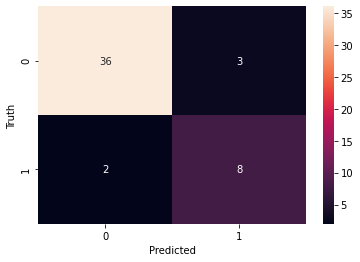

In [70]:
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [71]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.95      0.92      0.94        39
           1       0.73      0.80      0.76        10

    accuracy                           0.90        49
   macro avg       0.84      0.86      0.85        49
weighted avg       0.90      0.90      0.90        49



In [86]:
print("The accuracy Score is :",accuracy_score(y_test,y_predicted))

The accuracy Score is : 0.8979591836734694


## Testing model performance of unseen data 

Test question source : (click on links to go to the respective pages)
- [Science and tech](https://amigoz.app/mcq/s/t/technology-set-1-mcq-questions/5fb90b32de490d1fdcde3edb/?page=12)
- [History](https://www.gktoday.in/quizbase/ancient-indian-history-multiple-choice-questions?pageno=9)

In [92]:
prediction = model.predict(['In which decade was the ARRL founded?'])
if prediction > 0.5: # as is closer to 1 its Science & Tech and if it is closer to 0 it is History
    print('Science & Tech')
else :
    print('History')

Science & Tech


In [94]:
prediction = model.predict(['With respect to India’s trade with the West which of the following  ports on the western coast of India played an important during 600 A.D. to 1000 A.D.?'])
if prediction > 0.5: # as is closer to 1 its Science & Tech and if it is closer to 0 it is History
    print('Science & Tech')
else :
    print('History')

History


## SCOPE OF IMPROVEMENTS:
- Using more training data 
- Creating a deeper neural network

# THANK YOU !!